# Word2Vec

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./train/train.csv')

### Clean Data

In [3]:
import re

# Lowercase and remove punctuation
to_remove = ['.', ',', '?', '!', ':', ';']
replacement = " "

pattern = "|".join(map(re.escape, to_remove))
df["text"] = df["text"].str.replace(pattern, replacement, regex=True)
df["text"] = df["text"].str.lower()

print(df.head())

        id                                               text author
0  id26305  this process  however  afforded me no means of...    EAP
1  id17569  it never once occurred to me that the fumbling...    HPL
2  id11008  in his left hand was a gold snuff box  from wh...    EAP
3  id27763  how lovely is spring as we looked from windsor...    MWS
4  id12958  finding nothing else  not even gold  the super...    HPL


In [4]:
# Remove Samples with too Many Words
print(df.shape)
max_words = 100
df = df[df['text'].str.split().apply(len) <= max_words]
print(df.shape)

(19579, 3)
(19491, 3)


### Word2Vec

In [5]:
# import gensim
# from gensim.models import Word2Vec

# data = []

# # Tokenize the text data
# for i in range(len(df)):
#     temp = []
#     for j in range(len(df['text'].iloc[i].split())):
#         temp.append(df['text'].iloc[i].split()[j])
#     data.append(temp)

# print(data[:2])

In [6]:
# Train Word2Vec model
# wvmodel = gensim.models.Word2Vec(data, min_count=1,vector_size=100, window=5)

In [7]:
# word1 = 'chicken'
# word2 = 'butter'

# word_sim = wvmodel.wv.similarity(word1, word2) * 100
# word_sim = word_sim

# print(f"Similarity between {word1} and {word2}: {word_sim : .2f}%")

In [8]:
# print(wvmodel.wv.most_similar('penetrate', topn=5))

In [9]:
import gensim.downloader

# Load model
word2vec_model = gensim.downloader.load('glove-wiki-gigaword-100')

In [10]:
from gensim.utils import simple_preprocess
import torch
from torch.nn.utils.rnn import pad_sequence

tokens_list = []
vectorized_samples = []
kept_samples = []

for i, quote in enumerate(df['text']):
    tokens = simple_preprocess(quote)
    tokens_list.append(tokens)
    word_vectors = [word2vec_model[token] for token in tokens if token in word2vec_model]
    
    # Skip if no valid word vectors , empty or too long
    if len(word_vectors) == 0 or len(word_vectors) > 5000:
        kept_samples.append(False)
        continue
    
    kept_samples.append(True)
    vectorized_samples.append(torch.tensor(word_vectors))

padded_sequence = pad_sequence(vectorized_samples, batch_first=True)
print(f"Padded sequence shape: {padded_sequence.shape}")
print(f"Kept {len(vectorized_samples)} out of {len(df)} samples")
print(f"First sample shape: {padded_sequence[0].shape}")

/tmp/ipykernel_1233321/1614189253.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  vectorized_samples.append(torch.tensor(word_vectors))


Padded sequence shape: torch.Size([19491, 98, 100])
Kept 19491 out of 19491 samples
First sample shape: torch.Size([98, 100])


In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = torch.permute(pe.unsqueeze(0), (0, 2, 1))
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [12]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, latent_dim),
                )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        self.latent_dim = latent_dim
        
    def forward(self, x):
        original_shape = x.shape
        if len(original_shape) > 2:
            x = x.reshape(-1, original_shape[-1]) 
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        if len(original_shape) > 2:
            reconstructed = reconstructed.reshape(original_shape)

        return reconstructed, latent
    
    def get_latent_representation(self, x):
        original_shape = x.shape
        if len(original_shape) > 2:
            x = x.reshape(-1, x.shape[-1])
        latent = self.encoder(x)
        if len(original_shape) > 2:
            latent = latent.reshape(-1, original_shape[1], self.latent_dim)
        return latent


In [13]:
def masked_mse_loss(reconstruction, target, mask):
    
    squared_error = (reconstruction - target)**2
    mask_expanded = mask.unsqueeze(-1).expand_as(squared_error)
    masked_error = squared_error * mask_expanded
    sum_masked_error = torch.sum(masked_error)
    num_non_padded_elements = torch.sum(mask_expanded)
    
    return sum_masked_error / num_non_padded_elements

In [14]:
import torch.nn.init as init

class TransformerModel(nn.Transformer):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, noutput, dropout=0.3):
        super(TransformerModel, self).__init__(d_model=ninp, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, batch_first=True)
        self.pos_encoder = PositionalEncoding(ntoken, dropout, ninp)
        self.input_emb = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout, batch_first=True)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, noutput)
        
    def init_weights(self):
        init.xavier_uniform_(self.decoder.weight)
        init.constant_(self.decoder.bias, 0.)

        for p in self.encoder.parameters():
            if p.dim() > 1:
                init.xavier_uniform_(p)
            elif p.dim() == 1:
                init.constant_(p, 0.)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.encoder(src)
        output = output[:, -1, :]
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)

In [15]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

X = padded_sequence.to(device)
encoder = LabelEncoder()
y = encoder.fit_transform(df['author'][kept_samples].values.reshape(-1, 1))
y = torch.tensor(y, dtype=torch.long).to(device)
dataset = TensorDataset(X, y)
print(X.shape)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1])


torch.Size([19491, 98, 100])


/home/channing/ml_stuff/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
NINP = 100  # Original Transformer d_model/ninp  
HIDDEN_DIM = 50
LATENT_DIM = 32
BATCH_SIZE = 64
SEQUENCE_LENGTH = 98
AUTOENCODER_EPOCHS = 10
LEARNING_RATE = 1e-5
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# ae = Autoencoder(NINP, LATENT_DIM, HIDDEN_DIM).to(device=device)
# criterion = nn.MSELoss() 
# optimizer = torch.optim.Adam(ae.parameters(), lr=LEARNING_RATE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# training_losses = []
# val_losses = []
# for epoch in range(AUTOENCODER_EPOCHS):
#         # Training
#         ae.train()
#         train_loss = 0
#         for X_batch, y_batch in train_dataloader:
#             optimizer.zero_grad()
#             outputs, latent = ae.forward(X_batch)
#             loss = criterion(outputs, X_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#         train_loss /= len(train_dataloader)
#         training_losses.append(train_loss)

#         # Validation
#         ae.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for X_batch, y_batch in val_dataloader:
#                 outputs, latent = ae.forward(X_batch)
#                 loss = criterion(outputs, X_batch)
#                 val_loss += loss.item()
#         val_loss /= len(val_dataloader)
#         val_losses.append(val_loss)
# plt.figure(figsize=(10, 6))
# plt.plot(training_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

In [17]:
# ae.eval()
# compressed_embeddings = []
# outputs = []
# with torch.no_grad():
#     for X_batch, y_batch in train_dataloader:
#         latent_output = ae.get_latent_representation(X_batch)
#         compressed_embeddings.append(latent_output.cpu().numpy())
#         outputs.append(y_batch.cpu().numpy())
#     reduced_features = np.concatenate(compressed_embeddings, axis=0)
#     concat_outputs = np.concatenate(outputs, axis=0)
#     X = torch.tensor(reduced_features).to(device)
#     y = torch.tensor(concat_outputs).to(device)

#     train_dataset = TensorDataset(X, y)

#     for X_batch, y_batch in val_dataloader:
#         latent_output = ae.get_latent_representation(X_batch)
#         compressed_embeddings.append(latent_output.cpu().numpy())
#         outputs.append(y_batch.cpu().numpy())
#     reduced_features = np.concatenate(compressed_embeddings, axis=0)
#     concat_outputs = np.concatenate(outputs, axis=0)
#     X = torch.tensor(reduced_features).to(device)
#     y = torch.tensor(concat_outputs).to(device)

#     val_dataset = TensorDataset(X, y)
#     train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
#     val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    

In [18]:
# print(train_dataset[9])

In [19]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import joblib  # For saving/loading the study

def objective(trial):
    """Optuna objective function to minimize validation loss"""
    
    # Suggest hyperparameters
    nhid = trial.suggest_int('nhid', 32, 512)  # 128, 256, 384, 512
    nlayers = trial.suggest_int('nlayers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.6)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-4, log=True)
    
    # Create datasets with suggested batch size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model with suggested hyperparameters
    model = TransformerModel(
        X.shape[1], 
        ninp=X.shape[2],  # Keep embedding size fixed
        nhead=5,   # Keep nhead fixed (must divide ninp)
        nhid=nhid, 
        nlayers=nlayers, 
        noutput=3, 
        dropout=dropout
    ).to(device)
    
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    num_epochs = 50
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model.forward(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                outputs = model.forward(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_dataloader)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
        
        # Report intermediate value for pruning
        trial.report(val_loss, epoch)
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_loss

# Create study and optimize
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

print("Starting hyperparameter optimization...")
study.optimize(objective, n_trials=25, timeout=3600)

# Save the study
study_path = 'optuna_study.pkl'
joblib.dump(study, study_path)
print(f"\nStudy saved to {study_path}")

# Print results
print(f"\nBest trial: {study.best_trial.number}")
print(f"Best validation loss: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
  

/home/channing/ml_stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-19 20:39:19,504] A new study created in memory with name: no-name-e9ac2997-8279-4f22-9e9f-29ac98cdf6d6
/home/channing/ml_stuff/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Starting hyperparameter optimization...


[I 2025-11-19 20:39:30,467] Trial 0 finished with value: 0.8661853228845904 and parameters: {'nhid': 124, 'nlayers': 1, 'dropout': 0.36196011139552453, 'lr': 0.0030604915955365648, 'batch_size': 128, 'weight_decay': 4.85797092259807e-06}. Best is trial 0 with value: 0.8661853228845904.
/home/channing/ml_stuff/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
[I 2025-11-19 20:39:40,622] Trial 1 finished with value: 1.0333371683955193 and parameters: {'nhid': 208, 'nlayers': 2, 'dropout': 0.10246914729553633, 'lr': 0.005915669812432029, 'batch_size': 256, 'weight_decay': 6.190126287802766e-05}. Best is trial 0 with value: 0.8661853228845904.
[I 2025-11-19 20:39:59,671] Trial 2 finished with value: 0.8049884662032127 and parameters: {'nhid': 339, 'nlayers': 2, 'dropout': 0.46501023722641566, 'lr': 0.0005106444606617107, 'batch_siz


Study saved to optuna_study.pkl

Best trial: 22
Best validation loss: 0.6880
Best hyperparameters:
  nhid: 78
  nlayers: 2
  dropout: 0.16742720103101572
  lr: 0.0008264522888341778
  batch_size: 128
  weight_decay: 5.140504408792627e-07


In [ ]:
# To load the study later without rerunning optimization:
import joblib
study = joblib.load('optuna_study.pkl')
best_params = study.best_params
print("Loaded best hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Load the best model with these parameters
final_model = TransformerModel(
    X.shape[1], 
    ninp=100, 
    nhead=5, 
    nhid=best_params['nhid'], 
    nlayers=best_params['nlayers'], 
    noutput=3, 
    dropout=best_params['dropout']
).to(device)

# Load the saved weights
final_model.load_state_dict(torch.load("transformer_model_best_optuna.pt"))
final_model.eval()
print("\nBest model loaded successfully!")


Loaded best hyperparameters:
  nhid: 78
  nlayers: 2
  dropout: 0.16742720103101572
  lr: 0.0008264522888341778
  batch_size: 128
  weight_decay: 5.140504408792627e-07


/home/channing/ml_stuff/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for TransformerModel:
	Unexpected key(s) in state_dict: "encoder.layers.2.self_attn.in_proj_weight", "encoder.layers.2.self_attn.in_proj_bias", "encoder.layers.2.self_attn.out_proj.weight", "encoder.layers.2.self_attn.out_proj.bias", "encoder.layers.2.linear1.weight", "encoder.layers.2.linear1.bias", "encoder.layers.2.linear2.weight", "encoder.layers.2.linear2.bias", "encoder.layers.2.norm1.weight", "encoder.layers.2.norm1.bias", "encoder.layers.2.norm2.weight", "encoder.layers.2.norm2.bias". 
	size mismatch for encoder.layers.0.linear1.weight: copying a param with shape torch.Size([384, 100]) from checkpoint, the shape in current model is torch.Size([78, 100]).
	size mismatch for encoder.layers.0.linear1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([78]).
	size mismatch for encoder.layers.0.linear2.weight: copying a param with shape torch.Size([100, 384]) from checkpoint, the shape in current model is torch.Size([100, 78]).
	size mismatch for encoder.layers.1.linear1.weight: copying a param with shape torch.Size([384, 100]) from checkpoint, the shape in current model is torch.Size([78, 100]).
	size mismatch for encoder.layers.1.linear1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([78]).
	size mismatch for encoder.layers.1.linear2.weight: copying a param with shape torch.Size([100, 384]) from checkpoint, the shape in current model is torch.Size([100, 78]).
	size mismatch for decoder.weight: copying a param with shape torch.Size([3, 9800]) from checkpoint, the shape in current model is torch.Size([3, 100]).
	size mismatch for input_emb.linear1.weight: copying a param with shape torch.Size([384, 100]) from checkpoint, the shape in current model is torch.Size([78, 100]).
	size mismatch for input_emb.linear1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([78]).
	size mismatch for input_emb.linear2.weight: copying a param with shape torch.Size([100, 384]) from checkpoint, the shape in current model is torch.Size([100, 78]).

In [25]:
# Save best parameters separately as JSON for easy access
import json

best_params = study.best_params
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=4)
print("Best hyperparameters saved to best_hyperparameters.json")

# Visualize optimization history
fig = plot_optimization_history(study)
fig.show()

# Visualize parameter importance
fig = plot_param_importances(study)
fig.show()

# Show all trials
trials_df = study.trials_dataframe()
print("\nAll trials:")
print(trials_df[['number', 'value', 'params_nhid', 'params_nlayers', 'params_dropout', 'params_lr', 'params_batch_size']].sort_values('value'))


Best hyperparameters saved to best_hyperparameters.json


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

/home/channing/ml_stuff/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Training with early stopping (patience=5)...



  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▌         | 5/100 [00:02<00:43,  2.20it/s]

Epoch 5/100 - Train: 0.8587, Val: 0.8431, LR: 0.000826, Patience: 1/5


 10%|█         | 10/100 [00:04<00:41,  2.19it/s]

Epoch 10/100 - Train: 0.8087, Val: 0.8036, LR: 0.000826, Patience: 1/5


 15%|█▌        | 15/100 [00:06<00:39,  2.17it/s]

Epoch 15/100 - Train: 0.7771, Val: 0.7334, LR: 0.000826, Patience: 0/5


 20%|██        | 20/100 [00:09<00:36,  2.19it/s]

Epoch 20/100 - Train: 0.7361, Val: 0.7244, LR: 0.000826, Patience: 0/5


 25%|██▌       | 25/100 [00:11<00:34,  2.19it/s]

Epoch 25/100 - Train: 0.7181, Val: 0.7121, LR: 0.000826, Patience: 0/5


 30%|███       | 30/100 [00:13<00:31,  2.22it/s]

Epoch 30/100 - Train: 0.6863, Val: 0.7062, LR: 0.000826, Patience: 1/5


 35%|███▌      | 35/100 [00:15<00:29,  2.23it/s]

Epoch 35/100 - Train: 0.6582, Val: 0.6917, LR: 0.000413, Patience: 0/5


 40%|████      | 40/100 [00:18<00:26,  2.23it/s]

Epoch 40/100 - Train: 0.6536, Val: 0.6906, LR: 0.000413, Patience: 0/5


 45%|████▌     | 45/100 [00:20<00:24,  2.20it/s]

Epoch 45/100 - Train: 0.6417, Val: 0.6750, LR: 0.000413, Patience: 0/5


 50%|█████     | 50/100 [00:22<00:22,  2.18it/s]

Epoch 50/100 - Train: 0.6347, Val: 0.6931, LR: 0.000413, Patience: 2/5


 52%|█████▏    | 52/100 [00:24<00:22,  2.16it/s]


Early stopping triggered at epoch 53
Best validation loss: 0.6743

Loading best model from epoch 48


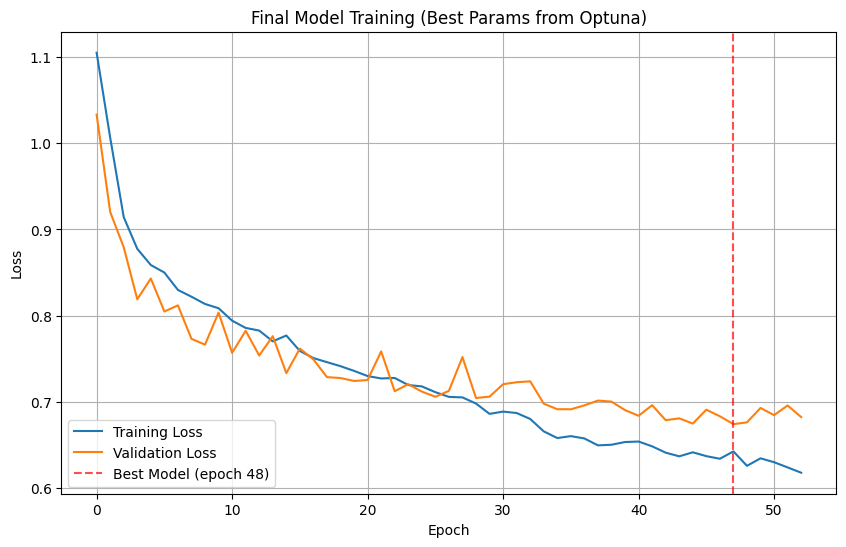


Best validation loss: 0.6743
Training stopped at epoch: 53
Best model saved at epoch: 48


In [28]:
from tqdm import tqdm

# Train final model with best hyperparameters
best_params = study.best_params

# Create final model
final_model = TransformerModel(
    X.shape[1], 
    ninp=100, 
    nhead=5, 
    nhid=best_params['nhid'], 
    nlayers=best_params['nlayers'], 
    noutput=3, 
    dropout=best_params['dropout']
).to(device)

# Create dataloaders with best batch size
final_train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    final_model.parameters(), 
    lr=best_params['lr'], 
    weight_decay=best_params['weight_decay']
)

# Scheduler decresases LR as val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
num_epochs = 100
training_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

print(f"Training with early stopping (patience={patience})...\n")

for epoch in tqdm(range(num_epochs)):
    # Training
    final_model.train()
    train_loss = 0
    for X_batch, y_batch in final_train_dataloader:
        optimizer.zero_grad()
        outputs = final_model.forward(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(final_train_dataloader)
    training_losses.append(train_loss)
    
    # Validation
    final_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in final_val_dataloader:
            outputs = final_model.forward(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(final_val_dataloader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        # Saves the best model
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(final_model.state_dict(), "transformer_model_best_optuna.pt")
    else:
        patience_counter += 1
        # Trigger early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break
    
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}, LR: {current_lr:.6f}, Patience: {patience_counter}/{patience}')

# Load best model
print(f"\nLoading best model from epoch {len(val_losses) - patience_counter}")
final_model.load_state_dict(torch.load("transformer_model_best_optuna.pt"))

# Plot final results
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
best_epoch = val_losses.index(min(val_losses))
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Model (epoch {best_epoch+1})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Final Model Training (Best Params from Optuna)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest validation loss: {best_val_loss:.4f}")
print(f"Training stopped at epoch: {len(val_losses)}")
print(f"Best model saved at epoch: {best_epoch+1}")

In [30]:
# LIME explainability to see which words impact prediction the most -> explain model predictions

# imports 
from lime.lime_text import LimeTextExplainer
from gensim.utils import simple_preprocess
import numpy as np
import torch
import os


embedding_dim = 100 # sets dimensions of each token embedding  
max_len = X.shape[1]
class_names = list(encoder.classes_) # class names

# helper: convert list[str] -> torch tensor shaped (batch, max_len, embedding_dim)
def texts_to_tensor(texts, word2vec_model, max_len=max_len, embedding_dim=embedding_dim, device=device):
    
    batch_size = len(texts)
    # start with zeros (float32)
    arr = np.zeros((batch_size, max_len, embedding_dim), dtype=np.float32)

    for i, txt in enumerate(texts):
        tokens = simple_preprocess(txt)  # same tokenizer used in training
        vecs = []
        for t in tokens:
            if t in word2vec_model:
                vecs.append(np.array(word2vec_model[t], dtype=np.float32))
        # if no known tokens, give one zero-vector (so model receives something)
        if len(vecs) == 0:
            vecs = [np.zeros(embedding_dim, dtype=np.float32)]

        # truncate to max_len and place at start of sequence
        vecs = vecs[:max_len]
        for j, v in enumerate(vecs):
            arr[i, j, :] = v

    # convert to torch tensor and move to device
    tensor = torch.from_numpy(arr).to(device)
    return tensor
  

def predict_proba_for_lime(texts):
    
    final_model.eval()
    X_tensor = texts_to_tensor(texts, word2vec_model, max_len=max_len, embedding_dim=embedding_dim, device=device)
    with torch.no_grad():
        # our model returns log_softmax, so apply exp to get probabilities
        logits = final_model.forward(X_tensor)
        probs = torch.exp(logits)  # convert log-probs -> probs
    return probs.cpu().numpy()


explainer = LimeTextExplainer(class_names=class_names) # create the LIME explainer 

# pick a sample text to explain (change index or text as you like)
sample_idx = 0  # explain the first kept sample by default
sample_text = df['text'][kept_samples].reset_index(drop=True).iloc[sample_idx]

# run explanation
explanation = explainer.explain_instance(sample_text,
                                         predict_proba_for_lime,
                                         num_features=10,
                                         labels=(0,1,2))  # explain for all classes

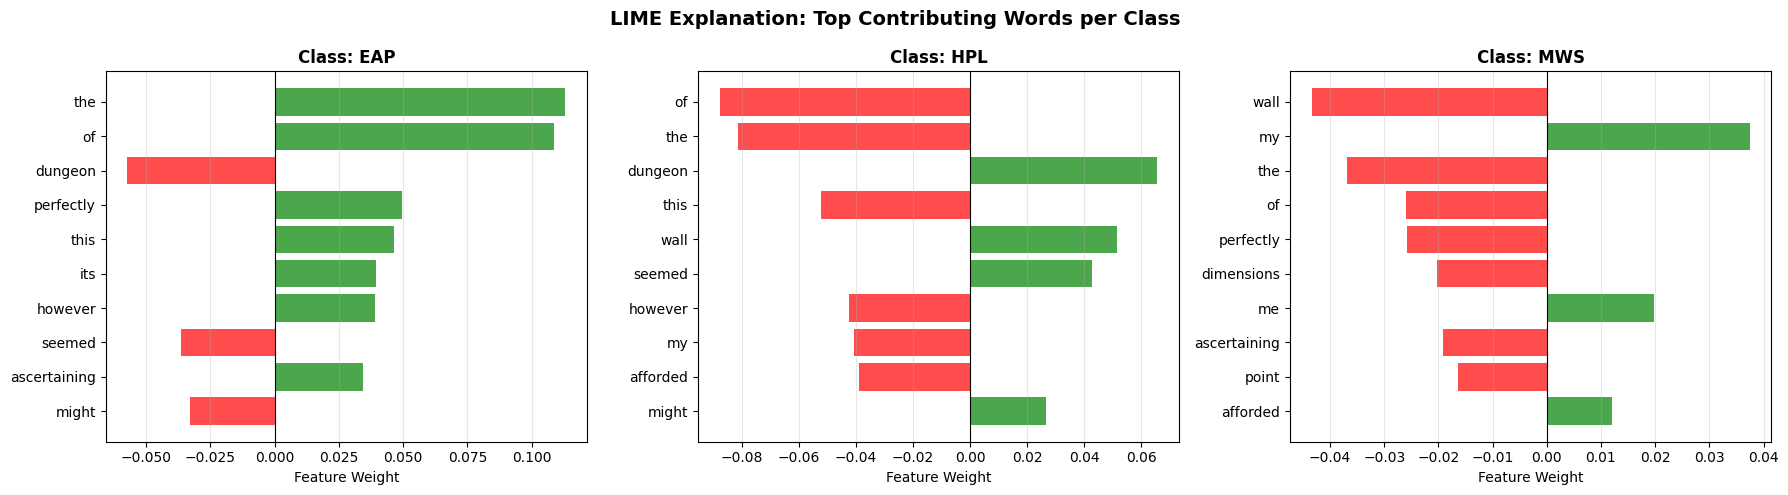


Top contributing tokens (word, weight) per class:

Class 'EAP':
[(np.str_('the'), 0.11308761324880423), (np.str_('of'), 0.10873195601040578), (np.str_('dungeon'), -0.05724011479968482), (np.str_('perfectly'), 0.0494884888863971), (np.str_('this'), 0.04660142656631288), (np.str_('its'), 0.03935065089983059), (np.str_('however'), 0.03892235413807877), (np.str_('seemed'), -0.03650413319170632), (np.str_('ascertaining'), 0.034329932397334534), (np.str_('might'), -0.03309384507629602)]

Class 'HPL':
[(np.str_('of'), -0.0878498173779041), (np.str_('the'), -0.08134102971438689), (np.str_('dungeon'), 0.0657101491226466), (np.str_('this'), -0.05212910878117296), (np.str_('wall'), 0.051361021672342126), (np.str_('seemed'), 0.042853300378141536), (np.str_('however'), -0.04233858837012184), (np.str_('my'), -0.04057187487112351), (np.str_('afforded'), -0.038901345825120386), (np.str_('might'), 0.026723680896625305)]

Class 'MWS':
[(np.str_('wall'), -0.043365724828761464), (np.str_('my'), 0.0374277

In [31]:
# Create visualization for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    
    # Get top features for this class
    features = explanation.as_list(label=class_idx)
    words = [f[0] for f in features]
    weights = [f[1] for f in features]
    
    # Color bars: green for positive (supports class), red for negative (opposes class)
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(words))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis()  # Top word at the top
    ax.set_xlabel('Feature Weight')
    ax.set_title(f'Class: {class_name}', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('LIME Explanation: Top Contributing Words per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print text summary
print("\nTop contributing tokens (word, weight) per class:")
for class_idx, class_name in enumerate(class_names):
    print(f"\nClass '{class_name}':")
    print(explanation.as_list(label=class_idx))

# Get predicted class
predicted_class_idx = np.argmax(predict_proba_for_lime([sample_text]))
print(f"\nSample text: '{sample_text[:100]}...'")
print(f"Predicted class: {class_names[predicted_class_idx]}\n")

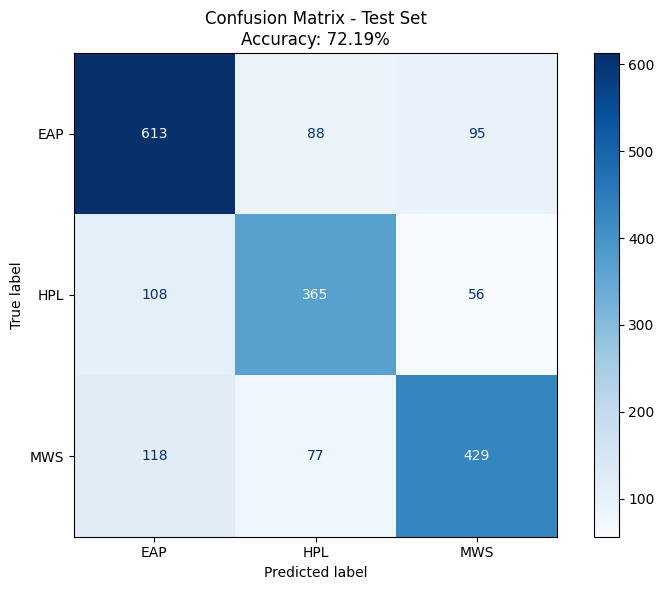


Classification Report:
              precision    recall  f1-score   support

         EAP       0.73      0.77      0.75       796
         HPL       0.69      0.69      0.69       529
         MWS       0.74      0.69      0.71       624

    accuracy                           0.72      1949
   macro avg       0.72      0.72      0.72      1949
weighted avg       0.72      0.72      0.72      1949


Test Accuracy: 72.19%


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
y_pred = []
y_actual = []

# Make predictions on test set
final_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        outputs = final_model.forward(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_actual.extend(y_batch.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * sum([1 for i, j in zip(y_pred, y_actual) if i == j]) / len(y_actual)

# Create confusion matrix
cm = confusion_matrix(y_actual, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {test_accuracy:.2f}%')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_actual, y_pred, target_names=encoder.classes_))
print(f"\nTest Accuracy: {test_accuracy:.2f}%")